# Non-Linear Classifiers

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 5

In [2]:
import numpy as np
import pandas as pd
import time
import math
import os
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Scoring Function

In [3]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, target_bins)):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        train_weight, valid_weight = train['sample_weight'].iloc[train_idx], train['sample_weight'].iloc[valid_idx]
    
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        try:
            model.fit(X_train, y_train, sample_weight = train_weight)
        except:
            model.fit(X_train, y_train)
        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = valid_weight)
        oof_preds[valid_idx] = valid_preds
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
    mask1, mask10 = train.gcd == 1, train.gcd == 10 
    mask1000, mask10000 = train.gcd == 1000, train.gcd == 10000
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[mask1], train['target'].loc[mask1], sample_weight = train['sample_weight'].loc[mask1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[mask10], train['target'].loc[mask10], sample_weight = train['sample_weight'].loc[mask10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[mask1000], train['target'].loc[mask1000], sample_weight = train['sample_weight'].loc[mask1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[mask10000], train['target'].loc[mask10000], sample_weight = train['sample_weight'].loc[mask10000]), 5))
    print("Out-of-Fold Accuracy:", round(accuracy_score(oof_preds, train['target'], sample_weight = train['sample_weight']), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Plot confusion matrix
def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [5]:
%%time
from sklearn.preprocessing import LabelEncoder

train = pd.read_feather('../data/train.feather')
features = [x for x in train.columns if x not in ['row_id','target','sample_weight','gcd']]

encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])
target_bins = train['target'].astype(str) + train['gcd'].astype(str)

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 1.12 s
Wall time: 195 ms


# Naive Bayes

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from math import factorial

def fix_bias(input_df, add = True):
    df = input_df.copy()
    bias = lambda w, x, y, z: factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)
    
    for col in features:
        w = int(col[1:col.index('T')])
        x = int(col[col.index('T')+1:col.index('G')])
        y = int(col[col.index('G')+1:col.index('C')])
        z = int(col[col.index('C')+1:])
        if add:
            df[col] = df[col] + bias(w, x, y, z)
        else:
            df[col] = df[col] - bias(w, x, y, z)
    return df


Fold 0: 0.55738 accuracy in 0.43s.
Fold 1: 0.56818 accuracy in 0.29s.
Fold 2: 0.54745 accuracy in 0.31s.
Fold 3: 0.56104 accuracy in 0.31s.
Fold 4: 0.55401 accuracy in 0.31s.

Accuracy (1M Reads): 0.61076
Accuracy (100k Reads): 0.61098
Accuracy (1k Reads): 0.56488
Accuracy (100 Reads): 0.4438
Out-of-Fold Accuracy: 0.55762
Training Time: 1.65s


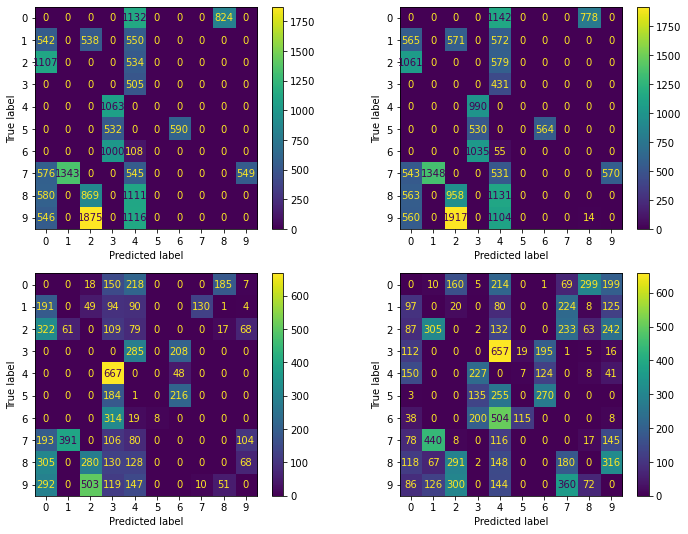

In [7]:
# Naive Bayes
oof_preds = score_model(
    MultinomialNB(),
    MinMaxScaler()
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'])

# KNN Classifier

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


Fold 0: 0.91848 accuracy in 3.23s.
Fold 1: 0.91989 accuracy in 3.25s.
Fold 2: 0.91832 accuracy in 3.45s.
Fold 3: 0.91746 accuracy in 3.47s.
Fold 4: 0.91839 accuracy in 3.42s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99998
Accuracy (1k Reads): 0.84836
Accuracy (100 Reads): 0.82578
Out-of-Fold Accuracy: 0.91851
Training Time: 16.82s


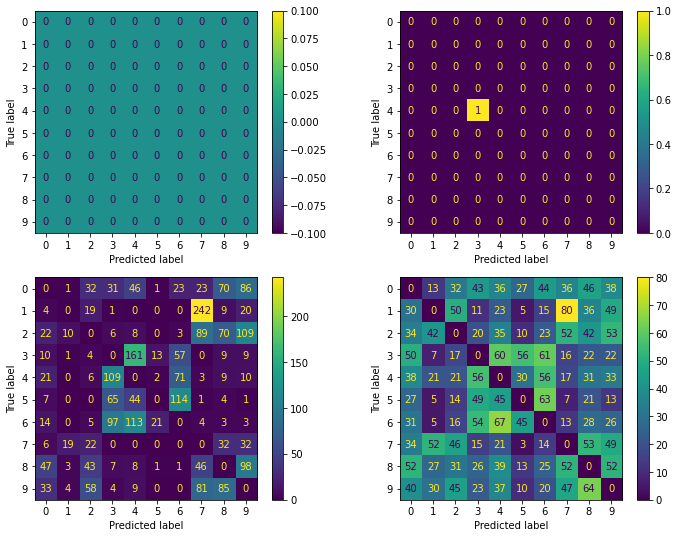

In [9]:
# KNN
oof_preds = score_model(
    KNeighborsClassifier(n_neighbors = 1),
    StandardScaler()
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'])

# Radius Neighbors


Fold 0: 0.36938 accuracy in 55.13s.
Fold 1: 0.36505 accuracy in 54.6s.
Fold 2: 0.36727 accuracy in 54.28s.
Fold 3: 0.37093 accuracy in 54.42s.
Fold 4: 0.37039 accuracy in 54.55s.

Accuracy (1M Reads): 0.88689
Accuracy (100k Reads): 0.38838
Accuracy (1k Reads): 0.09996
Accuracy (100 Reads): 0.09964
Out-of-Fold Accuracy: 0.3686
Training Time: 272.97s


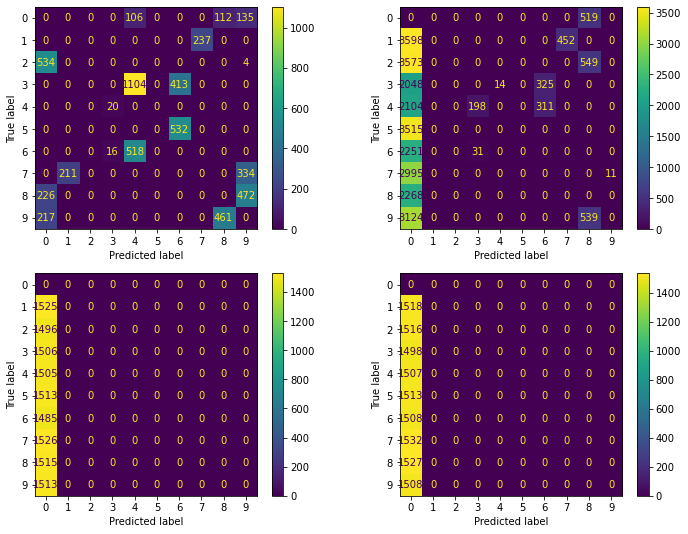

In [10]:
from sklearn.neighbors import RadiusNeighborsClassifier

# Radius Neighbors
oof_preds = score_model(
    RadiusNeighborsClassifier(
        n_jobs = -1,
        outlier_label = 'most_frequent',
    ),
    StandardScaler()
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'])

# Nearest Centroid


Fold 0: 0.51745 accuracy in 0.52s.
Fold 1: 0.52542 accuracy in 0.51s.
Fold 2: 0.5295 accuracy in 0.55s.
Fold 3: 0.53634 accuracy in 0.56s.
Fold 4: 0.51784 accuracy in 0.53s.

Accuracy (1M Reads): 0.56773
Accuracy (100k Reads): 0.57384
Accuracy (1k Reads): 0.55603
Accuracy (100 Reads): 0.40347
Out-of-Fold Accuracy: 0.52529
Training Time: 2.66s


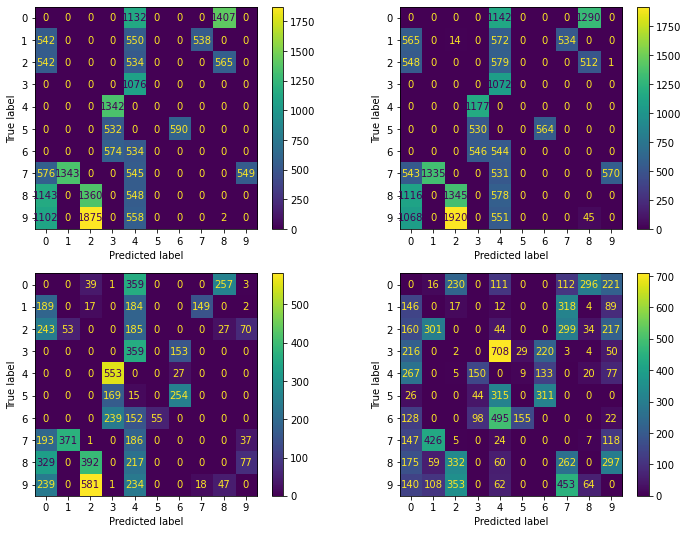

In [11]:
from sklearn.neighbors import NearestCentroid

# Nearest Centroid
oof_preds = score_model(
    NearestCentroid(),
    StandardScaler()
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'])

#  Support Vector Machines


Fold 0: 0.90259 accuracy in 17.89s.
Fold 1: 0.90317 accuracy in 18.06s.
Fold 2: 0.90762 accuracy in 17.77s.
Fold 3: 0.90415 accuracy in 17.83s.
Fold 4: 0.90168 accuracy in 17.53s.

Accuracy (1M Reads): 0.95937
Accuracy (100k Reads): 0.9743
Accuracy (1k Reads): 0.92233
Accuracy (100 Reads): 0.75928
Out-of-Fold Accuracy: 0.90384
Training Time: 89.09s


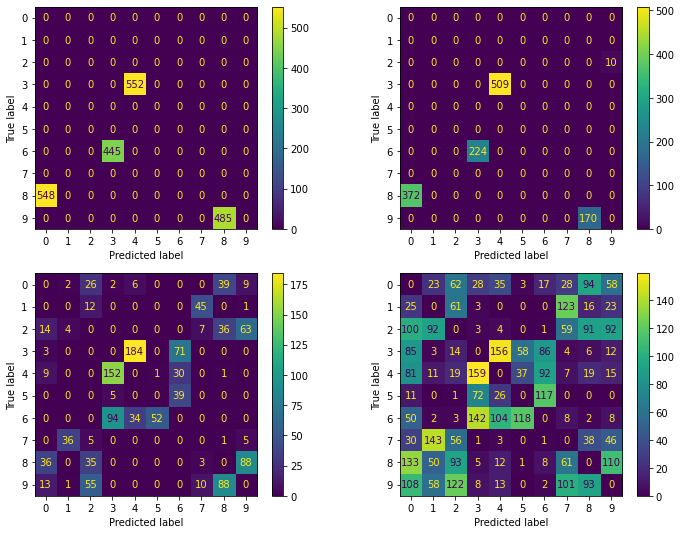

In [12]:
from sklearn.svm import SVC

# Polynomial SVM
oof_preds = score_model(
    SVC(kernel = "poly", degree = 2, coef0 = 1),
    StandardScaler()
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'])


Fold 0: 0.93306 accuracy in 28.33s.
Fold 1: 0.92856 accuracy in 27.51s.
Fold 2: 0.92868 accuracy in 29.49s.
Fold 3: 0.93257 accuracy in 29.49s.
Fold 4: 0.92989 accuracy in 28.31s.

Accuracy (1M Reads): 0.96342
Accuracy (100k Reads): 0.98104
Accuracy (1k Reads): 0.9288
Accuracy (100 Reads): 0.84891
Out-of-Fold Accuracy: 0.93055
Training Time: 143.12s


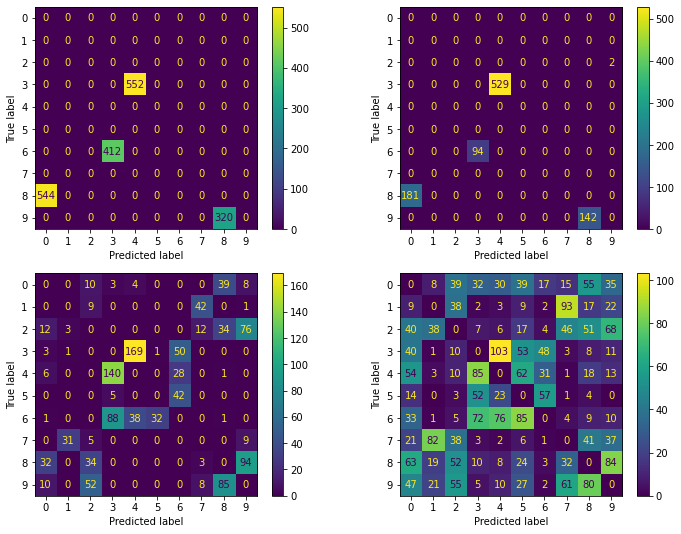

In [13]:
# Polynomial SVM
oof_preds = score_model(
    SVC(kernel = "rbf"),
    StandardScaler()
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'])